In [29]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbols_list = sp500['Symbol'].unique().tolist()
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)
df = yf.download(tickers=symbols_list, start = start_date, end = end_date)
df = df.stack(level=1)
df.index.names = ['date', 'ticker']
print(df.head())

[*********************100%***********************]  502 of 502 completed

4 Failed downloads:
['VLTO', 'GEV', 'SW', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


Price              Adj Close      Close  ...       Open       Volume
date       ticker                        ...                        
2015-09-29 A             NaN  31.185329  ...  30.834101    2252400.0
           AAPL          NaN  24.536381  ...  25.384558  293461600.0
           ABBV          NaN  35.061218  ...  35.267107   12842800.0
           ABT           NaN  32.820751  ...  32.621333   12287500.0
           ACGL          NaN  23.217773  ...  22.983217    1888800.0

[5 rows x 6 columns]


In [99]:
'''df['garman_klass_vol'] = (((np.log(df['High']) - np.log(df['Low']))**2)/2) - ((2*np.log(2)-1)*(np.log(df['Close'])-np.log(df['Open']))**2)
df['rsi'] = df.groupby(level=1)['Close'].transform(lambda x: pandas_ta.rsi(close = x, length=20))

def compute_bbands(group):
    bands = pandas_ta.bbands(close=np.log1p(group['Close']), length=20)
    return group.assign(
        bb_low=bands['BBL_20_2.0'],
        bb_mid=bands['BBM_20_2.0'],
        bb_high=bands['BBU_20_2.0']
    )
df = df.groupby(level=1, group_keys=False).apply(compute_bbands)
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['High'], low = stock_data['Low'], close = stock_data['Close'], length =14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr']= df.groupby(level=1, group_keys = False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close = close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['Close'].apply(compute_macd)
'''

df['dollar_volume'] = (df['Close']*df['Volume'])/1e6

df


Price              Adj Close       Close  ...      macd  dollar_volume
date       ticker                         ...                         
2015-09-29 A             NaN   31.185329  ...       NaN      70.241836
           AAPL          NaN   24.536381  ...       NaN    7200.485558
           ABBV          NaN   35.061218  ...       NaN     450.284214
           ABT           NaN   32.820751  ...       NaN     403.284980
           ACGL          NaN   23.217773  ...       NaN      43.853730
...                      ...         ...  ...       ...            ...
2023-09-26 XYL           NaN   87.701065  ... -2.159189     115.975888
           YUM           NaN  119.860710  ... -1.363696     179.862982
           ZBH           NaN  110.513588  ... -0.881066     399.009309
           ZBRA          NaN  223.960007  ... -1.600791      79.595386
           ZTS           NaN  173.604675  ... -1.188278     254.018361

[978406 rows x 14 columns]

<Axes: xlabel='date'>

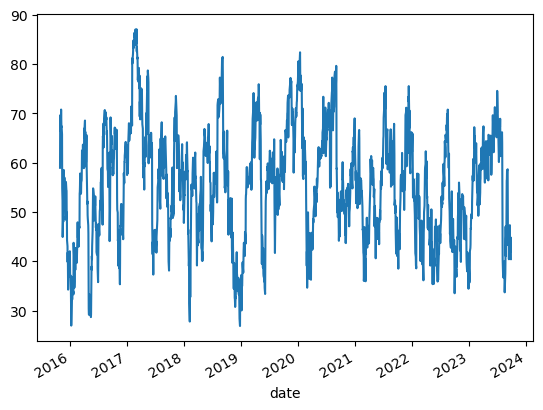

In [32]:
df.xs('AAPL', level=1)['rsi'].plot()

In [114]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume','Volume', 'Open', 'High','Low', 'Adj Close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')
        ,df.unstack()[last_cols].resample('M').last().stack('ticker')],
        axis=1).dropna()

data

dollar_volume       Close  ...       atr      macd
date       ticker                             ...                    
2015-11-30 A          134.704657   38.653534  ... -1.042157  0.567157
           AAPL      4005.252836   26.729136  ... -0.976120 -0.142789
           ABBV       325.730935   38.977577  ... -0.758486  0.145677
           ABT        207.499334   37.540985  ... -1.097931  0.335558
           ACGL        28.174423   22.970539  ... -1.155694 -0.550166
...                          ...         ...  ...       ...       ...
2023-09-30 EXE        116.689769   79.277847  ... -0.890969 -0.831788
           COIN       506.793576   70.519997  ... -1.183735  0.049978
           CEG        195.364208  107.145660  ... -0.396677  0.366875
           GEHC       211.929512   66.022324  ... -0.892836 -1.116463
           KVUE       646.494198   19.281166  ... -0.872136 -1.435620

[46196 rows x 9 columns]

In [ ]:
#data['dollar_volume'] = (data['dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())

#data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

#data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis =1)

data

garman_klass_vol        rsi  ...       atr      macd
date       ticker                               ...                    
2020-10-31 AAPL            0.000601  43.770338  ...  1.386834 -0.628202
           ABBV            0.000492  47.517637  ... -0.130544 -0.994068
           ABT             0.000265  48.047142  ...  0.962561 -0.069482
           ACN             0.000165  42.280764  ...  0.509317 -0.949113
           ADBE            0.000472  39.586497  ...  1.001552 -1.003552
...                             ...        ...  ...       ...       ...
2023-09-30 WDC             0.000366  55.763705  ... -1.391551  0.486892
           WFC             0.000234  40.920294  ... -0.226361 -0.282325
           WMT             0.000024  54.722549  ... -0.075667  0.399459
           WYNN            0.000142  36.293547  ... -1.240117 -0.693417
           XOM             0.000045  59.440171  ...  0.885843  1.400622

[5364 rows x 7 columns]

In [115]:
def calculate_returns(df):
    df = df.reset_index()
    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['Close'].pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                        upper = x.quantile(1-outlier_cutoff)))
                                                        .add(1)
                                                        .pow(1/lag)
                                                        .sub(1))
    return df.set_index(['date', 'ticker'])

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

dollar_volume       Close  ...  return_9m  return_12m
date       ticker                             ...                       
2016-11-30 A          106.745185   41.088646  ...   0.019227    0.005104
           AAPL      3486.687005   25.526880  ...   0.016838   -0.003828
           ABBV       390.233769   42.329323  ...   0.015097    0.006898
           ABT        289.131681   32.617073  ...   0.000125   -0.011648
           ACGL        27.154381   26.219442  ...   0.022112    0.011085
...                          ...         ...  ...        ...         ...
2023-09-30 DASH       230.583668   74.580002  ...   0.048207    0.034241
           ABNB      1633.500725  132.279999  ...   0.048608    0.019401
           EXE        116.689769   79.277847  ...  -0.009966   -0.004748
           COIN       506.793576   70.519997  ...   0.078169    0.007477
           CEG        195.364208  107.145660  ...   0.026987    0.023339

[40231 rows x 15 columns]

In [158]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start = '2010')[0].drop('RF', axis=1)

factor_data.index = pd.to_datetime(factor_data.index.to_timestamp())

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2016-11-30,0.0485,0.0696,0.0829,-0.0024,0.0371,-0.021601
2016-12-31,0.0181,0.0044,0.0347,0.0124,-0.0032,0.047955
2017-01-31,0.0194,-0.0144,-0.0276,-0.0051,-0.0106,0.047746
2017-02-28,0.0355,-0.0230,-0.0150,0.0045,-0.0180,0.133777
2017-03-31,0.0017,0.0075,-0.0333,0.0063,-0.0095,0.048690


In [167]:
observations =  factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 20]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

print(factor_data.shape)
print(factor_data.head())
factor_data

(40187, 6)
                   Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-11-30 A       0.0485  0.0696  0.0829 -0.0024  0.0371   0.009410
           AAPL    0.0485  0.0696  0.0829 -0.0024  0.0371  -0.021601
           ABBV    0.0485  0.0696  0.0829 -0.0024  0.0371   0.089996
           ABT     0.0485  0.0696  0.0829 -0.0024  0.0371  -0.029816
           ACGL    0.0485  0.0696  0.0829 -0.0024  0.0371   0.060921


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-11-30 A       0.0485  0.0696  0.0829 -0.0024  0.0371   0.009410
           AAPL    0.0485  0.0696  0.0829 -0.0024  0.0371  -0.021601
           ABBV    0.0485  0.0696  0.0829 -0.0024  0.0371   0.089996
           ABT     0.0485  0.0696  0.0829 -0.0024  0.0371  -0.029816
           ACGL    0.0485  0.0696  0.0829 -0.0024  0.0371   0.060921
...                   ...     ...     ...     ...     ...        ...
2023-09-30 XYL    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.135407
           YUM    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.041506
           ZBH    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.055910
           ZBRA   -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.185630
           ZTS    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.071597

[40187 rows x 6 columns]

In [169]:
betas = (factor_data.groupby(level=1,
                    group_keys = False)
                    .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                                window = (20),
                                                min_nobs = len(x.columns)+1)
                    .fit(params_only = True)
                    .params
                    .drop('const', axis=1))
)